# Exploring the Guardian Authorship dataset

In this notebook we'll take a look at the Guardian Authorship dataset on HuggingFace.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def load_guardian_authorship():
    configs = [
        'cross_topic_1', 'cross_topic_2', 'cross_topic_3', 'cross_topic_4', 'cross_topic_5', 
        'cross_topic_6', 'cross_topic_7', 'cross_topic_8', 'cross_topic_9', 'cross_topic_10', 
        'cross_topic_11', 'cross_topic_12', 'cross_genre_1', 'cross_genre_2', 'cross_genre_3', 
        'cross_genre_4'
    ]
    dataset = []
    for config in configs:
        ds = load_dataset('guardian_authorship', config)
        
        splits = ['train', 'test', 'validation']
        dfs = []
        for split in splits:
            df = ds[split].data.to_pandas()
            df['dataset'] = config
            df['split'] = split
            dfs.append(df)
        dataset.append(pd.concat(dfs))
    return pd.concat(dataset)

In [3]:
guardian_authorship_path = '../data/guardian_authorship.csv'
if not os.path.exists(guardian_authorship_path):
    guardian_authorship = load_guardian_authorship()
    guardian_authorship.to_csv(guardian_authorship_path, index=False)
guardian_authorship = pd.read_csv(guardian_authorship_path)

In [4]:
print("There are {:,} examples in the dataset".format(len(guardian_authorship)))

There are 6,348 examples in the dataset


In [5]:
guardian_authorship

,author,topic,article,dataset,split
0,6,0,I know your New Year's Day will not be complet...,cross_topic_1,train
1,6,0,Every summer the graduates of Britain's univer...,cross_topic_1,train
2,6,0,Just before the Leicester South by-election on...,cross_topic_1,train
3,6,0,The scandal of the moment is that Sir Mark Tha...,cross_topic_1,train
4,6,0,As the stock market crash makes comparisons wi...,cross_topic_1,train
...,...,...,...,...,...
6343,12,3,Whatever the truth of Naomi Wolf's sex-pest ac...,cross_genre_4,validation
6344,12,3,This year I had the good fortune to celebrate ...,cross_genre_4,validation
6345,9,3,It was Geoffrey Hoon who converted and convinc...,cross_genre_4,validation
6346,9,3,During his first term as vice president of the...,cross_genre_4,validation


In [6]:
# datasets = sorted(guardian_authorship.dataset.unique(), key = lambda x: (x.split('_')[-2], int(x.split('_')[-1])))
datasets = [
    'cross_genre_1', 'cross_genre_2', 'cross_genre_3', 'cross_genre_4',
    'cross_topic_1', 'cross_topic_2', 'cross_topic_3', 'cross_topic_4',
    'cross_topic_5', 'cross_topic_6', 'cross_topic_7', 'cross_topic_8',
    'cross_topic_9', 'cross_topic_10', 'cross_topic_11', 'cross_topic_12'
]

In [7]:
for split in ['train', 'validation', 'test']:
    num_split = len(guardian_authorship[guardian_authorship.split == split])
    print(f"Number of {split} examples: \t{num_split}")
print()

num_authors = len(guardian_authorship.author.unique())
num_topics = len(guardian_authorship.topic.unique())

print("Number of unique authors:\t{}".format(num_authors))
print("Number of unique topics:\t{}".format(num_topics))

print()
for dataset in datasets:
    num_dataset = len(guardian_authorship[guardian_authorship.dataset == dataset])
    print(f"Number of {dataset} examples: {num_dataset}")

Number of train examples: 	1395
Number of validation examples: 	1524
Number of test examples: 	3429

Number of unique authors:	13
Number of unique topics:	5

Number of cross_genre_1 examples: 444
Number of cross_genre_2 examples: 444
Number of cross_genre_3 examples: 444
Number of cross_genre_4 examples: 444
Number of cross_topic_1 examples: 381
Number of cross_topic_2 examples: 381
Number of cross_topic_3 examples: 381
Number of cross_topic_4 examples: 381
Number of cross_topic_5 examples: 381
Number of cross_topic_6 examples: 381
Number of cross_topic_7 examples: 381
Number of cross_topic_8 examples: 381
Number of cross_topic_9 examples: 381
Number of cross_topic_10 examples: 381
Number of cross_topic_11 examples: 381
Number of cross_topic_12 examples: 381


Text(0.5, 1.0, 'Histogram of word count per training example')

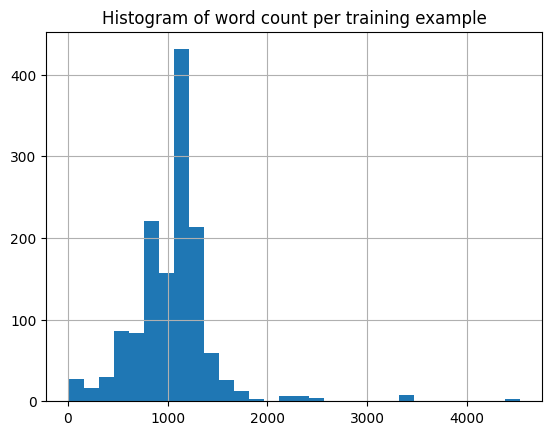

In [8]:
guardian_authorship[guardian_authorship.split == 'train'].article.str.split(' ').apply(len).hist(bins=30)
plt.title('Histogram of word count per training example')

In [ ]:
# Function to preprocess the text
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenization and punctuation removal can be handled by TfidfVectorizer
    return text

# Apply preprocessing to the article column
guardian_authorship['processed'] = guardian_authorship['article'].apply(preprocess)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Function to compute TF-IDF and return a DataFrame with top 30 words
def compute_tfidf(dataframe, groupby_field):
    # Group by the specified field and join all articles into a single document per group
    grouped_data = dataframe.groupby(groupby_field)['processed'].apply(lambda x: ' '.join(x))
    
    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_data)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create a DataFrame for TF-IDF scores
    tfidf_scores = tfidf_matrix.toarray()
    tfidf_df = pd.DataFrame(tfidf_scores, index=grouped_data.index, columns=feature_names)
    
    # Get the 30 most significant words for each group
    top_words = tfidf_df.apply(lambda s: s.nlargest(30).index.tolist(), axis=1)
    top_scores = tfidf_df.apply(lambda s: s.nlargest(30).tolist(), axis=1)
    
    # Construct the final DataFrame
    top_tfidf_df = pd.DataFrame({
        'group': top_words.index,
        'top_words': top_words.values,
        'top_scores': top_scores.values
    }).reset_index(drop=True)
    
    return top_tfidf_df

# Compute top 30 TF-IDF words for each topic
top_words_by_topic = compute_tfidf(guardian_authorship, 'topic')

# Compute top 30 TF-IDF words for each author
top_words_by_author = compute_tfidf(guardian_authorship, 'author')

In [11]:
top_words_by_topic

,group,top_words,top_scores
0,0,"[labour, blair, new, people, government, time,...","[0.233861895112355, 0.22858114264207602, 0.181..."
1,1,"[new, people, government, public, labour, nhs,...","[0.22204969852999995, 0.21956869631178766, 0.2..."
2,2,"[people, public, royal, queen, like, new, just...","[0.18289999216879374, 0.15109129787856876, 0.1..."
3,3,"[bush, world, war, new, people, israel, americ...","[0.25920712369983245, 0.18999105252113058, 0.1..."
4,4,"[book, like, time, life, world, just, years, p...","[0.18410118755763893, 0.17350543575576044, 0.1..."


In [12]:
top_words_by_author

,group,top_words,top_scores
0,0,"[blair, people, br, like, burrell, diana, time...","[0.1979298173849619, 0.15778367517952152, 0.14..."
1,1,"[government, nuclear, people, rwandan, new, we...","[0.2041687840482288, 0.19541005831458805, 0.18..."
2,2,"[bush, people, war, public, political, governm...","[0.20814180692964604, 0.16981890674443334, 0.1..."
3,3,"[obama, israel, hamas, israeli, state, new, ju...","[0.23408357926964238, 0.21204029665808158, 0.1..."
4,4,"[bush, nelson, time, blair, labour, kerry, yea...","[0.28265702453616304, 0.1589273014599069, 0.13..."
5,5,"[children, cent, new, government, people, like...","[0.1570464200312492, 0.14814205057286642, 0.14..."
6,6,"[br, labour, said, people, new, blair, war, ma...","[0.180682133869778, 0.1377236639790972, 0.1280..."
7,7,"[years, like, time, just, way, new, bush, cour...","[0.1424065765055125, 0.1395003198421347, 0.138..."
8,8,"[people, new, government, world, time, public,...","[0.197324836706647, 0.17639057112283768, 0.149..."
9,9,"[labour, government, party, minister, new, pub...","[0.20911768347298798, 0.18174993295135533, 0.1..."
